# Домашнее задание

### Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.


### Часть 1. Анализ текстов
1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### Часть 2. Тематическое моделирование
1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?
Эта часть задания может быть сделана с использованием gensim.

### Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
Используйте accuracy и F-measure для оценки качества классификации.

В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

## Посмотрим пример отзыва

In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import seaborn as sns
import re
from tqdm import tqdm_notebook as tqdm
from collections import Counter

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

/home/polina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


0it [00:00, ?it/s]

In [4]:
# Сколько всего записей:
len(responses)

153499

In [5]:
# Пример отзыва:
responses[1234]

{'city': 'г. Воронеж',
 'rating_not_checked': False,
 'title': 'Платеж через терминал Сбербанка',
 'num_comments': 0,
 'bank_license': 'лицензия № 1481',
 'author': 'nadivlasova',
 'bank_name': 'Сбербанк России',
 'datetime': '2015-05-24 18:28:14',
 'text': 'Добрый день!  14.05.15 я оплатила наличными через терминал Сбербанка счет проводного интернета Билайн. Все данные были введены верно, однако платеж не поступил на счет. В колл-центре Сбербанка, куда я обратилась, мне сказали подождать 3 банковских (то есть рабочих) дня. Но и в течение 3х рабочих дней платеж не был зачислен.  20.05.15 я обратилась в отделение Сбербанка (г. Воронеж, доп.офис 9013/0139, ул. Новгородская, 121), где совершала платеж. Сотрудник Людмила Н-а, принявшая у меня паспорт и чек, сказала, что проверит информацию.  В итоге я ждала 20 минут, о времени ожидания меня не предупредили, о причинах задержки тоже. Начальник доп. офиса подошла к Людмиле Н-й и сделала ей замечание, так как, видимо, она слишком долго рассма

### Часть 1. Анализ текстов

In [6]:
data = pd.DataFrame(responses)

In [7]:
data.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


#### 1. Посчитайте количество отзывов в разных городах и на разные банки

In [9]:
# Всего банков
len(data['bank_name'].unique())

670

In [10]:
# Количество отзывов по банкам:
data['bank_name'].value_counts()

Сбербанк России                  26327
Альфа-Банк                       10224
ВТБ 24                            8185
Русский Стандарт                  7943
Хоум Кредит Банк                  7549
                                 ...  
Финанс Бизнес Банк                   1
Независимый Банк Развития            1
Алмазэргиэнбанк                      1
Современные Стандарты Бизнеса        1
Уралкапиталбанк                      1
Name: bank_name, Length: 670, dtype: int64

In [11]:
# Количество отзывов по городам:
#data['city'].value_counts()

In [12]:
# Уберем строки, где поле город пустое
data = data.dropna(subset = {'city'})

In [13]:
# Всего вариантов в поле "Город":
len(unique(data['city']))

5823

Используем библиотеку natasha, чтобы нормализовать названия городов:

In [14]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

In [15]:
def normalize(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)
    normals = []
    for span in doc.spans:
        if span.type == 'LOC':
            span.normalize(morph_vocab)
            normals.append(span.normal)
    normals_str = ' '.join((str(n) for n in normals))
    normals_str = normals_str.lower()
    return normals_str

In [16]:
data['city_normalized'] = data['city'].apply(lambda x: normalize(str(x)))

In [17]:
data.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_normalized
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,москва
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,новосибирск
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,москва
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,ставрополь
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,челябинск


In [18]:
# всего "городов" после обработки:
len(unique(data['city_normalized']))

2828

In [19]:
#отзывы по городам:
data['city_normalized'].value_counts()

москва                          55702
санкт-петербург                 14478
                                 9205
екатеринбург                     2353
новосибирск                      2316
                                ...  
мильково                            1
нижний новгород бор                 1
балтийск калининградская обл        1
ракитное                            1
ковров владимирская область         1
Name: city_normalized, Length: 2828, dtype: int64

In [20]:
# посчитаем количество "городов" с одним отзывом:
vals = data['city_normalized'].value_counts()
vals = vals[vals < 2]
len(vals)

1744

In [21]:
# всего записей:
len(data)

138325

In [22]:
len(vals)/len(data)*100

1.2607988433038135

Все же видно, что этой обработки недостаточно, так как могут оставаться такие варианты, как "новосибирк москва","уфа ульяновск" и другие. Однако доля таких записей от общего количества отзывов - всего 1,26 процента. Будем считать их выбросами, и что в какой-то момент можем их не учитывать.

2. Постройте гистограмы длин слов в символах и в словах

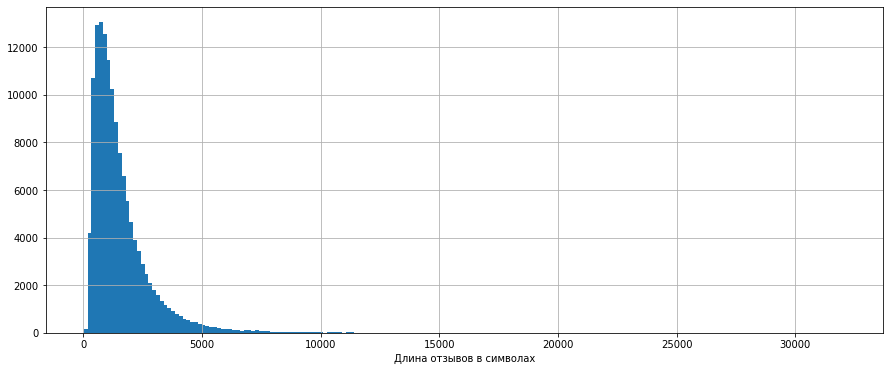

In [23]:
# В символах:
symbols = data['text'].apply(len)
rcParams['figure.figsize'] = 15, 6
symbols.plot(kind='hist',bins=200, grid = 'on')
plt.xlabel('Длина отзывов в символах')
plt.ylabel('')
plt.show()

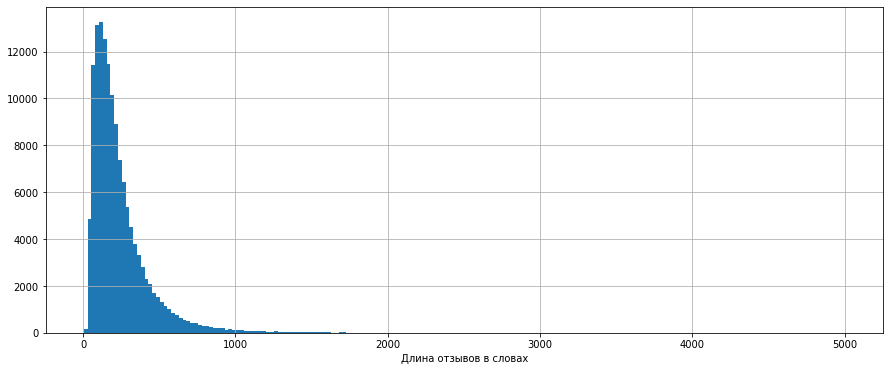

In [24]:
# В словах:
words =  data['text'].str.split().apply(len)
rcParams['figure.figsize'] = 15, 6
words.plot(kind='hist',bins=200, grid = 'on')
plt.xlabel('Длина отзывов в словах')
plt.ylabel('')
plt.show()

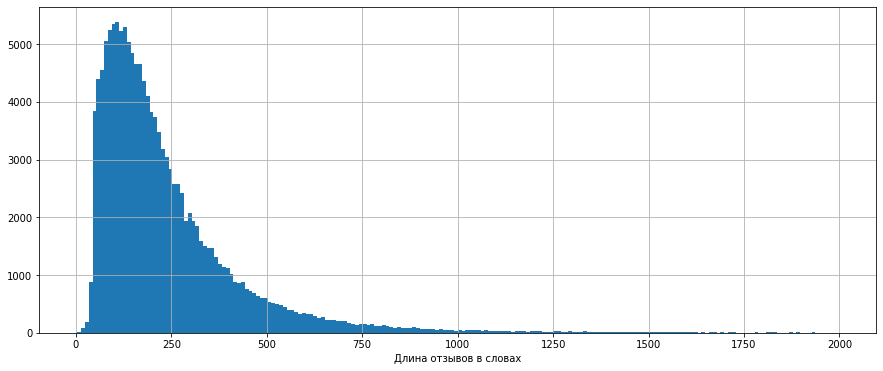

In [25]:
# В словах, где меньше 2000 слов:
words =  data['text'].str.split().apply(len)
rcParams['figure.figsize'] = 15, 6
words[words<2000].plot(kind='hist',bins=200, grid = 'on')
plt.xlabel('Длина отзывов в словах')
plt.ylabel('')
plt.show()

Найдите 10 самых частых:  
- слов  
- слов без стоп-слов  
- лемм  
- существительных  

#### Слова

In [26]:
data['text'][0]

'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно,\xa0 и почему по Вашей милости я должна переживать и бояться за себе и свое имущество. Письма доставляют мн

In [27]:
segmenter = Segmenter()

In [28]:
def extract_words(text):
    doc_string = re.sub(r'[^\w\s]', '', text)
    doc_string = doc_string.lower()
    doc = Doc(doc_string)
    doc.segment(segmenter)
    tokens = []
    for token in doc.tokens:
        tokens.append(token.text)

    return tokens

In [29]:
words = pd.DataFrame(data['text'].apply(lambda x: extract_words(str(x))))

In [30]:
words.head()

,text
0,"[добрый, день, я, не, являюсь, клиентом, банка..."
1,"[доброго, дня, являюсь, держателем, зарплатной..."
2,"[здравствуйте, дублирую, свое, заявление, от, ..."
3,"[добрый, день, я, открыл, расчетный, счет, в, ..."
4,"[04032015, г, взяла, кредит, в, вашем, банке, ..."


In [31]:
cnt = Counter()

In [32]:
for index, row in words.iterrows(): 
    cnt.update(row['text'])

In [33]:
cnt.most_common(10) 

[('в', 1204133),
 ('и', 958713),
 ('не', 777305),
 ('на', 641247),
 ('что', 566556),
 ('я', 527908),
 ('с', 416352),
 ('по', 336108),
 ('мне', 294850),
 ('банка', 244855)]

#### Cлов без стоп-слов

In [34]:
from nltk.corpus import stopwords

stopwords_ext = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также', 'т', 'д', 'г']

In [35]:
def remove_digits(parts):
    for part in parts:
        if part.isnumeric():
            parts.remove(part)
    return parts

In [36]:
def remove_stopwords(text, stopwords_list):
    try:
        text = remove_digits(text)
        return " ".join([word for word in text if not word in stopwords_list])
    except:
        return ""

In [37]:
words_clean = words.copy()

In [38]:
words_clean['text_clean'] = words_clean['text'].apply(lambda x: remove_stopwords(x,stopwords_ext))

In [39]:
words_clean

,text,text_clean
0,"[добрый, день, я, не, являюсь, клиентом, банка...",добрый день являюсь клиентом банка поручителем...
1,"[доброго, дня, являюсь, держателем, зарплатной...",доброго дня являюсь держателем зарплатной карт...
2,"[здравствуйте, дублирую, свое, заявление, от, ...",здравствуйте дублирую свое заявление можайский...
3,"[добрый, день, я, открыл, расчетный, счет, в, ...",добрый день открыл расчетный счет сбербанке юр...
4,"[г, взяла, кредит, в, вашем, банке, заявленная...",взяла кредит вашем банке заявленная мною сумма...
...,...,...
138574,"[являюсь, вкладчиком, павловского, осб, югозап...",являюсь вкладчиком павловского осб югозападног...
138576,"[мая, года, внес, тыс, руб, через, банкомат, н...",мая года внес руб банкомат вр конверт июня обн...
138578,"[почитала, я, тут, отзывы, о, своем, банке, ка...",почитала отзывы своем банке карта которого рук...
138585,"[после, кражи, карты, предыдущего, банка, gemo...",кражи карты предыдущего банка gemoney решил во...


In [40]:
cnt = Counter()

for index, row in words_clean.iterrows(): 
    cnt.update(row['text_clean'].split())

In [41]:
cnt.most_common(10) 

[('банка', 244855),
 ('банк', 180831),
 ('деньги', 119008),
 ('карту', 97238),
 ('карты', 94794),
 ('кредит', 72055),
 ('день', 69841),
 ('заявление', 65103),
 ('отделение', 60652),
 ('время', 59347)]

#### Леммы

In [42]:
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem

In [43]:
m = Mystem()

def lemmatize(text, mystem=m):
    try:
        return " ".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [44]:
words_clean['lemmatized'] = words_clean['text_clean'].apply(lemmatize)

In [45]:
words_clean['lemmatized']

0         добрый   день   являться   клиент   банк   пор...
1         добрый   день   являться   держатель   зарплат...
2         здравствовать   дублировать   свой   заявление...
3         добрый   день   открывать   расчетный   счет  ...
4         взять   кредит   ваш   банк   заявлять   я   с...
                                ...                        
138574    являться   вкладчик   павловский   осб   югоза...
138576    май   год   вносить   руб   банкомат   вр   ко...
138578    почитать   отзыв   свой   банк   карта   котор...
138585    кража   карта   предыдущий   банк   gemoney   ...
138946    здравствовать   закрывать   карта   метро   но...
Name: lemmatized, Length: 138325, dtype: object

In [46]:
cnt = Counter()
lemmas = []
words_number = []
all_tokens = []
tokens = []

for index, row in words_clean.iterrows():
    tokens = row['lemmatized'].split()
    cnt.update(tokens)
    all_tokens+=tokens
    lemmas.append(len(cnt))
    words_number.append(sum(list(cnt.values())))

In [47]:
cnt.most_common(10) 

[('банк', 536209),
 ('карта', 308775),
 ('деньги', 162787),
 ('день', 158075),
 ('мой', 155982),
 ('кредит', 139955),
 ('который', 136719),
 ('отделение', 130000),
 ('счет', 127764),
 ('сотрудник', 124599)]

#### Существительные

In [ ]:
m=MorphAnalyzer()

def to_noun(text):
    m=MorphAnalyzer()
    try:
        res = " ".join([noun for noun in text.split() if m.parse(noun)[0].tag.POS =='NOUN'])
        return res
    
    except:
        return []

to_noun(words_clean['lemmatized'].iloc[10])

In [ ]:
words_clean['nouns'] = words_clean['lemmatized'].apply(lambda x: to_noun(x))

In [ ]:
for index, row in words_clean.iterrows():  
    cnt.update(row['nouns'].split())

In [ ]:
cnt.most_common(10) 

### 4. Постройте кривые Ципфа и Хипса

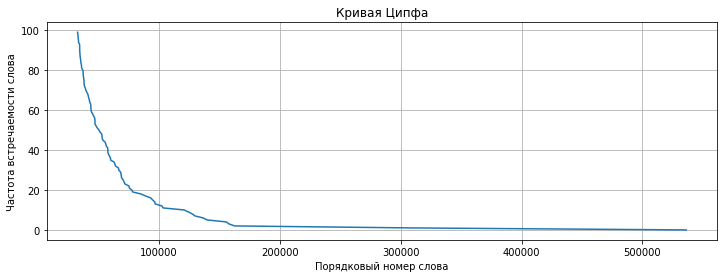

In [48]:
frequency = sorted(list(cnt.values()),reverse = True)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(frequency[:100], range(100))
grid(visible = 'True')
plt.xlabel('Порядковый номер слова')
plt.ylabel('Частота встречаемости слова')
plt.title('Кривая Ципфа')
plt.show()

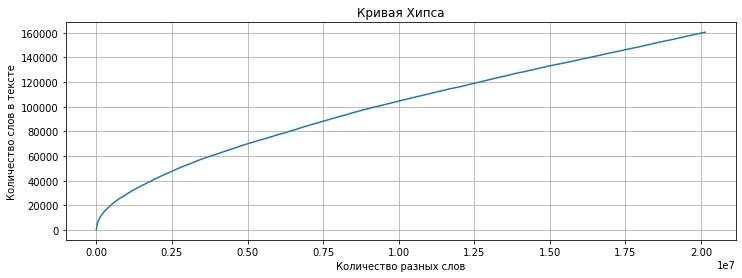

In [49]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(words_number,lemmas)
grid(visible = 'True')
plt.xlabel('Количество разных слов')
plt.ylabel('Количество слов в тексте')
plt.title('Кривая Хипса')
plt.show()

### 5. Ответьте на следующие вопросы:
* какое слово встречается чаще, "сотрудник" или "клиент"?
* сколько раз встречается слова "мошенничество" и "доверие"?

In [50]:
from nltk import FreqDist
Freq_Dist = FreqDist(all_tokens)

In [51]:
print(f'Слово "сотрудник" встречается ', {Freq_Dist['сотрудник']},' раз')
print(f'Слово "клиент" встречается ', {Freq_Dist['клиент']},' раз')
print(f'Слово "мошенничество" встречается ',{Freq_Dist['мошенничество']}, ' раз')
print(f'Слово "доверие" встречается ' ,{Freq_Dist['доверие']}, 'раз')

Слово "сотрудник" встречается  {124599}  раз
Слово "клиент" встречается  {120949}  раз
Слово "мошенничество" встречается  {3105}  раз
Слово "доверие" встречается  {1932} раз


### 6.
В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру  𝑡𝑓−𝑖𝑑𝑓 , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [52]:
data['rating_grade'].value_counts()

1.0    39855
2.0    13252
5.0    10511
3.0     7521
4.0     3571
Name: rating_grade, dtype: int64

In [53]:
dataset = data.copy()
dataset.head(1)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_normalized
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,москва


In [54]:
dataset['text_clean'] = words_clean['text_clean']
dataset['lemmatized'] = words_clean['lemmatized']

In [55]:
dataset = dataset.dropna(subset = {'rating_grade'})

In [56]:
num=10000

data_sample = dataset[(dataset['rating_grade']==1.0)].sample(n=num).copy()
data_sample = data_sample.append(dataset[(dataset['rating_grade']==5.0)].sample(n=num))

In [57]:
topic_tokens = []

for rating in data_sample['rating_grade'].unique():
    tokens=[]
    sample=data_sample[data_sample['rating_grade']==rating]
    
    for i in range(len(sample)):
        tokens += sample['lemmatized'].iloc[i].split()
        
    topic_tokens.append(tokens)

In [58]:
data_sample.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_normalized,text_clean,lemmatized
78705,г. Самара,False,Кредитное мошенничество,9,лицензия № 2766,ndk63,ОТП Банк,2013-07-17 21:47:00,"Добрый день! Не буду повторяться, всем известн...",1.0,самара,добрый день буду повторяться всем известны мно...,добрый день быть повторяться все изв...
129303,г. Москва,False,Москва,2,лицензия № 3292,hart99,Райффайзенбанк,2010-11-18 15:52:00,"Уважаемые читающие, расскажу Вам историю, как ...",1.0,москва,уважаемые читающие расскажу историю кажется за...,уважаемый читать рассказывать история ...
86615,г. москва,False,Подключили страховку без согласия,3,лицензия № 2289,zavchik,Русский Стандарт,2013-04-06 21:26:00,Оформлял карту в отделении на Валовой улице в ...,1.0,,оформлял карту отделении валовой улице москве ...,оформлять карта отделение валовой улиц...


### Униграммы

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [60]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in topic_tokens])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_5 = []
tfidf_ranking_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_1.append(phrase)

In [61]:
rank = pd.DataFrame({'tfidf_ranking_5': tfidf_ranking_5,'tfidf_ranking_1': tfidf_ranking_1})
rank.head(10)

,tfidf_ranking_5,tfidf_ranking_1
0,банк,банк
1,карта,карта
2,очень,деньги
3,клиент,день
4,день,мой
5,сотрудник,отделение
6,который,который
7,кредит,сотрудник
8,отделение,счет
9,вклад,кредит


In [62]:
# Убираем пересечения

In [63]:
rank['tfidf_ranking_5_without_1']=rank.tfidf_ranking_5[~rank.tfidf_ranking_5.isin(rank.tfidf_ranking_1)]
rank['tfidf_ranking_1_without_5']=rank.tfidf_ranking_1[~rank.tfidf_ranking_1.isin(rank.tfidf_ranking_5)]

In [64]:
rank.iloc[:,-2:].dropna()

,tfidf_ranking_5_without_1,tfidf_ranking_1_without_5
21,спасибо,ответ
31,быстро,номер
39,банка,средство
40,отзыв,говорить
42,хороший,рубль
53,услуга,претензия
56,процент,срок
57,новый,давать
58,самый,почему
64,предлагать,знать


### Биграммы

In [65]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in topic_tokens])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase) 

In [66]:
rankings = pd.DataFrame({'tfidf_ranking_rank_is_5': tfidf_ranking_rank_is_5,'tfidf_ranking_rank_is_1': tfidf_ranking_rank_is_1})
rankings.head(10)

,tfidf_ranking_rank_is_5,tfidf_ranking_rank_is_1
0,другой банк,сотрудник банк
1,сотрудник банк,отделение банк
2,кредитный карта,написать заявление
3,клиент банк,денежный средство
4,открывать вклад,кредитный карта
5,отделение банк,горячий линия
6,являться клиент,рабочий день
7,следующий день,ваш банк
8,добрый день,другой банк
9,дебетовый карта,следующий день


In [67]:
rankings['tfidf_ranking_rank_is_5_without_1']=rankings.tfidf_ranking_rank_is_5[~rankings.tfidf_ranking_rank_is_5.isin(rankings.tfidf_ranking_rank_is_1)]
rankings['tfidf_ranking_rank_is_1_without_5']=rankings.tfidf_ranking_rank_is_1[~rankings.tfidf_ranking_rank_is_1.isin(rankings.tfidf_ranking_rank_is_5)]

In [68]:
rankings.iloc[:,-2:].dropna()

,tfidf_ranking_rank_is_5_without_1,tfidf_ranking_rank_is_1_without_5
12,хотеть выражать,сей пора
14,процентный ставка,получать ответ
18,год назад,кредитный договор
21,очень довольный,обращаться отделение
22,интернет банк,отделение сбербанк
23,мой вопрос,номер телефон
24,пользоваться услуга,писать заявление
26,банк очень,течение день
27,отношение клиент,мой карта
28,большой спасибо,мой деньги


### Часть 2. Тематическое моделирование

#### 1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [69]:
import gensim.corpora as corpora
from gensim.models import ldamodel

In [70]:
words_theme = words_clean.copy()
texts = [words_theme['lemmatized'].iloc[i].split() for i in range(len(words_theme))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [71]:
random.seed(5)

In [72]:
# построим модель для 20 тем
lda20 = ldamodel.LdaModel(corpus=corpus, 
                        id2word=dictionary, 
                        num_topics=20, 
                        alpha='auto', 
                        eta='auto', 
                        iterations = 20, 
                        passes = 5)

In [73]:
# Посмотрим 3 темы:
lda20.show_topics(3)

[(18,
  '0.118*"_" + 0.092*"курс" + 0.082*"доллар" + 0.082*"валюта" + 0.072*"евро" + 0.035*"валютный" + 0.033*"рубль" + 0.032*"рублевый" + 0.026*"конвертация" + 0.017*"сша"'),
 (3,
  '0.017*"сказать" + 0.016*"деньги" + 0.015*"говорить" + 0.011*"звонить" + 0.010*"такой" + 0.010*"приходить" + 0.010*"знать" + 0.010*"мочь" + 0.009*"банк" + 0.009*"просто"'),
 (5,
  '0.062*"банк" + 0.023*"клиент" + 0.014*"очень" + 0.010*"который" + 0.010*"свой" + 0.009*"время" + 0.008*"год" + 0.008*"другой" + 0.007*"работа" + 0.007*"проблема"')]

Темы:
1. Судебные иски и влияние их на взаимодействие клиента с банком (просьбы об отсрочке и тд)
2. Качество обслуживания клиентов сотрудниками банка
3. Сложно интерпретировать эту тему, но, возможно, проблемы с кредитными выплатами у клиента.

In [74]:
# построим модель для 10 тем
lda10 = ldamodel.LdaModel(corpus=corpus, 
                        id2word=dictionary, 
                        num_topics=10, 
                        alpha='auto', 
                        eta='auto', 
                        iterations = 20, 
                        passes = 5)

In [75]:
# Посмотрим 3 темы:
lda10.show_topics(3)

[(4,
  '0.109*"вклад" + 0.041*"открывать" + 0.036*"банк" + 0.024*"деньги" + 0.023*"процент" + 0.023*"депозит" + 0.022*"счет" + 0.020*"договор" + 0.016*"открытие" + 0.013*"условие"'),
 (1,
  '0.033*"банк" + 0.019*"клиент" + 0.012*"очень" + 0.010*"очередь" + 0.009*"работать" + 0.009*"время" + 0.009*"работа" + 0.008*"который" + 0.008*"свой" + 0.008*"сотрудник"'),
 (3,
  '0.017*"сказать" + 0.014*"день" + 0.013*"банк" + 0.012*"отделение" + 0.010*"говорить" + 0.010*"звонить" + 0.010*"позвонить" + 0.009*"приходить" + 0.009*"мочь" + 0.009*"девушка"')]

Темы:
1. Правовые вопросы при заключении договора с банком
2. Возможные жалобы на время/качество работы отделений банка
3. Отзывы на работу сотрудников банка

In [76]:
# построим модель для 5 тем
lda5 = ldamodel.LdaModel(corpus=corpus, 
                        id2word=dictionary, 
                        num_topics=5, 
                        alpha='auto', 
                        eta='auto', 
                        iterations = 20, 
                        passes = 5)

In [77]:
# Посмотрим 3 темы:
lda5.show_topics(3)

[(0,
  '0.038*"банк" + 0.018*"мой" + 0.014*"сотрудник" + 0.011*"ваш" + 0.010*"телефон" + 0.010*"звонок" + 0.010*"данный" + 0.009*"который" + 0.009*"клиент" + 0.008*"номер"'),
 (1,
  '0.049*"карта" + 0.017*"банк" + 0.015*"день" + 0.013*"заявление" + 0.012*"отделение" + 0.011*"деньги" + 0.011*"мой" + 0.010*"сказать" + 0.009*"получать" + 0.009*"позвонить"'),
 (2,
  '0.024*"банк" + 0.011*"клиент" + 0.008*"отделение" + 0.008*"вклад" + 0.007*"очень" + 0.007*"работать" + 0.007*"время" + 0.007*"офис" + 0.007*"который" + 0.006*"свой"')]

1. Кредит в банке, кредитный договор
2. Получение денег в банкомате и в отделении банка
3. Сотрудник банка при работе с клинтом по вкладу

### 2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

In [78]:
for theme in lda5.show_topics():
    if theme[1].find('сбербанк')> 0:
        print(theme)

Получение, вопросы, связанные с получением денег  в банкомате Сбербанка и в отделении

In [79]:
for theme in lda20.show_topics():
    if theme[1].find('сбербанк')> 0:
        print(theme)

Вопросы, проблемы по смс-банкингу

## Часть 3. Классификация текстов

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). 

2. Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.  
3. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных  𝑛 -грам.  
4. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант:  𝑡𝑓−𝑖𝑑𝑓  преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

In [80]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [81]:
datacopy = data.copy()
datacopy['text_clean'] = words_clean['text_clean']
datacopy['lemmatized'] = words_clean['lemmatized']


num=2000

dataset = datacopy[(datacopy['rating_grade']==1.0)].sample(n=num).copy()
dataset = dataset.append(datacopy[(datacopy['rating_grade']==5.0)].sample(n=num))

In [82]:
dataset.head(1)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_normalized,text_clean,lemmatized
108226,г. Москва,False,Накопилось...,1,лицензия № 1623,advance,ВТБ 24,2012-05-13 17:14:00,Отношения с банком стартовали в 2006 г. Ипотеч...,1.0,москва,отношения банком стартовали ипотечный кредит т...,отношение банк стартовать ипотечный кр...


In [83]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 108226 to 99497
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                4000 non-null   object 
 1   rating_not_checked  4000 non-null   bool   
 2   title               4000 non-null   object 
 3   num_comments        4000 non-null   int64  
 4   bank_license        4000 non-null   object 
 5   author              4000 non-null   object 
 6   bank_name           4000 non-null   object 
 7   datetime            4000 non-null   object 
 8   text                4000 non-null   object 
 9   rating_grade        4000 non-null   float64
 10  city_normalized     4000 non-null   object 
 11  text_clean          4000 non-null   object 
 12  lemmatized          4000 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 410.2+ KB


In [84]:
X = dataset['lemmatized'].values
y = dataset['rating_grade'].values

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Baseline:

In [86]:
clf_countvectorized = Pipeline([('vect', CountVectorizer()),('clf', LogisticRegression())])

params_cntv = {
    'vect__analyzer': ['word','char'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3)),
    'clf__C': np.logspace(-3,3,7),
    'clf__penalty': ['l1','l2']  
}

scores=['accuracy', 'f1']

grid_cntv = GridSearchCV(
    clf_countvectorized, 
    param_grid=params_cntv, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

grid_cntv.fit(X_train, y_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


/home/polina/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.87749869 0.7857192  0.7332146  0.87464244 0.7857192  0.7332146
 0.86856923 0.7857192  0.7332146  0.58392834 0.82678695 0.91250011
 0.58428867 0.84928772 0.90857204 0.71929597 0.86142803 0.90107395
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.91214628 0.83393044 0.69928117 0.91321771 0.83393044 0.69928117
 0.91286082 0.83393044 0.69928117 0.58392604 0.85178325 0.92000087
 0.58321418 0.86928759 0.91357268 0.71286778 0.87642459 0.90750023
        nan        nan        nan        nan     

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'clf__penalty': ['l1', 'l2'],
                         'vect__analyzer': ['word', 'char'],
                         'vect__max_df': (0.5, 0.75, 1.0),
                         'vect__ngram_range': ((1, 1), (2, 2), (3, 3))},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [2]:
# print(grid_cntv.best_estimator_)
print("Best score: %0.3f" % grid_cntv.best_score_)

NameError: name 'grid_cntv' is not defined

In [3]:
# print(grid_cntv.best_estimator_)
#print("Best score: %0.3f" % grid_cntv.best_score_)

In [4]:
predictions=grid_cntv.best_estimator_.predict(X_test)

NameError: name 'grid_cntv' is not defined

In [5]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

NameError: name 'precision_score' is not defined

In [6]:
print(classification_report(y_test, predictions))

NameError: name 'classification_report' is not defined

- 1-ый вариант: 
$tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer)

In [125]:
clf_tf_idf = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression())]
)


params_tf_idf={
    'vect__analyzer': ['word'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
}

scores=['accuracy','f1']

In [1]:
grid_tf_idf = GridSearchCV(
    clf_tf_idf, 
    param_grid=params_tf_idf, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

NameError: name 'GridSearchCV' is not defined

In [ ]:
grid_tf_idf.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [ ]:
print("Best score: %0.3f" % grid_tf_idf.best_score_)
predictions=grid_tf_idf.best_estimator_.predict(X_test)

In [ ]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
labels = grid_tf_idf.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False, 
    xticklabels=labels, 
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

- 1-ый вариант: 
сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),

In [ ]:
clf_tf_idf_TruncatedSVD = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('tsvd', TruncatedSVD()),
     ('clf', LogisticRegression())]
)

params_tf_idf_TruncatedSVD={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tsvd__n_components': [5, 10, 25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
}

scores=['accuracy','f1']

In [ ]:
grid_tf_idf_TruncatedSVD = GridSearchCV(
    clf_tf_idf_TruncatedSVD, 
    param_grid=params_tf_idf_TruncatedSVD, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [ ]:
grid_tf_idf_TruncatedSVD.fit(X_train, y_train)

In [ ]:
print("Best score: %0.3f" % grid_tf_idf_TruncatedSVD.best_score_)

In [ ]:
predictions=grid_tf_idf_TruncatedSVD.best_estimator_.predict(X_test)

In [ ]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
labels = grid_tf_idf_TruncatedSVD.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False, 
    xticklabels=labels, 
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

- 2-й вариант. LDA

In [ ]:
clf_tf_idf_LDA = Pipeline(
    [('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('clf', LogisticRegression())]
)

params_tf_idf_LDA={
    'vect__analyzer': ['word'],
    'vect__max_df': [0.75],
    'vect__ngram_range': [(1, 1)],
    'lda__n_components' : [25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1']
}

scores=['accuracy', 'f1']

In [ ]:
grid_tf_idf_LDA = GridSearchCV(
    clf_tf_idf_LDA, 
    param_grid=params_tf_idf_LDA, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [ ]:
grid_tf_idf_LDA.fit(X_train, y_train)

In [ ]:
print("Best score: %0.3f" % grid_tf_idf_LDA.best_score_)

In [ ]:
predictions=grid_tf_idf_LDA.best_estimator_.predict(X_test)

In [ ]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
labels = grid_tf_idf_LDA.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

In [ ]:
### 

In [ ]:
models=['grid_cntv', 'grid_tf_idf', 'grid_tf_idf_TruncatedSVD', 'grid_tf_idf_LDA']

for model in models:
    print(model[5:])
    predictions=eval(model).best_estimator_.predict(X_test)
    print("f1_score: {0:6.3f}\nAccuracy: {0:6.3f}\n\n".format(
        f1_score(y_test, predictions, average='macro'), 
        accuracy_score(y_test, predictions)))